# <FONT size="10pt"> <center>Projet 7</center></FONT>


### Notebook 4

#### <FONT size="10pt"> <center>Implémentez un modèle de scoring</center></FONT>



### Mission de Data Scientist pour "Prêt à dépenser"

En tant que Data Scientist chez "Prêt à dépenser", une société financière spécialisée dans les crédits à la consommation pour des clients ayant peu ou pas d'historique de prêt, vous êtes chargé de développer un outil de "scoring crédit" pour évaluer la probabilité qu'un client rembourse son prêt.

#### Objectifs de la mission :

1. **Construction du Modèle de Scoring** :
   - Développer un algorithme de classification capable de prédire automatiquement la probabilité de faillite d'un client en utilisant des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

2. **Analyse des Features** :
   - Identifier les caractéristiques (features) qui contribuent le plus au modèle de manière générale (importance globale des features).
   - Analyser l'importance des features au niveau individuel (importance locale des features) pour permettre aux chargés d'études de comprendre le score attribué à chaque client.

3. **Mise en Production** :
   - Déployer le modèle de scoring via une API.
   - Créer une interface de test pour cette API afin de faciliter son utilisation et sa validation.

4. **Approche MLOps** :
   - Mettre en place une approche MLOps complète, incluant le suivi des expérimentations et l'analyse du data drift en production pour assurer la robustesse et la pertinence continue du modèle.


### Les données :

1. **application_train/application_test** : Ces fichiers contiennent les données principales pour l'entraînement et le test. Chaque ligne représente une demande de prêt chez Prêt à dépenser, identifiée par l'attribut SK_ID_CURR. Les données d'entraînement incluent une colonne TARGET indiquant si le prêt a été remboursé (0) ou non (1).

2. **bureau** : Ce fichier contient des informations sur les crédits antérieurs des clients auprès d'autres institutions financières. Chaque ligne correspond à un crédit antérieur, et un prêt existant dans application_train/application_test peut être associé à plusieurs crédits antérieurs.

3. **bureau_balance** : Ces données mensuelles fournissent des informations sur les crédits antérieurs mentionnés dans le fichier bureau. Chaque ligne correspond à un mois de crédit, et un crédit unique peut avoir plusieurs lignes, une pour chaque mois de sa durée.

4. **previous_application** : Ce fichier recense les demandes de prêts précédentes des clients auprès de Prêt à dépenser. Chaque ligne correspond à une demande antérieure de prêt, identifiée par l'attribut SK_ID_PREV. Un prêt actuel dans application_train/application_test peut avoir plusieurs demandes de prêts antérieures.

5. **POS_CASH_BALANCE** : Ces données mensuelles concernent les prêts au point de vente ou les prêts en espèces contractés par les clients auprès de Prêt à dépenser. Chaque ligne représente un mois de prêt au point de vente ou de prêt en espèces, avec plusieurs lignes possibles pour un même prêt.

6. **credit_card_balance** : Ce fichier contient des données mensuelles sur les cartes de crédit des clients. Chaque ligne correspond à un mois de solde de carte de crédit, avec plusieurs lignes possibles pour une même carte de crédit.

7. **installments_payment** : Ce fichier documente l'historique des paiements pour les prêts antérieurs. Chaque ligne représente un paiement effectué ou manqué.

L'objectif est de combiner ces différentes sources de données pour construire un modèle de scoring précis qui peut aider Prêt à dépenser à évaluer le risque de crédit de leurs clients.

## IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [1]:
### Importations de base
import numpy as np
import pandas as pd
import os
import gc
import time
import timeit
import datetime
import random
import statistics
import warnings
from contextlib import contextmanager

### Importations pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import missingno as msno
from tqdm.notebook import tqdm
from IPython.display import display, HTML

### Importations pour la manipulation des données
import re
from scipy import stats

### Importations pour le Machine Learning
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc,  roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn import cluster, metrics
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

### Importations pour MLFLOW
import mlflow
import mlflow.sklearn

### Importations pour SHAP et gestion des avertissements spécifiques
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import shap
shap.initjs()
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Paramètres pandas
pd.set_option('mode.chained_assignment', None)  # Pour éviter la survenue de messages d'erreur lors de la création d'un nouveau dataframe à partir d'un existant
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.options.display.width = 50
pd.options.display.max_colwidth = 1000

### Optionnel : Filtrer les avertissements
from warnings import filterwarnings
filterwarnings('ignore')

### Optionnel : Ajuster la largeur de l'écran pour IPython
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

**Concernant l’élaboration du modèle soyez vigilant sur deux points spécifiques au contexte métier :** 

- Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, avec une méthode au choix.
- Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge).
   - Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
   - Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.

In [2]:
# Parallélisation avec joblib
from joblib import Parallel, delayed

# Fonction pour élever un nombre au carré (utilisée pour illustrer la parallélisation avec joblib)
def process_data_joblib(i):
    return i * i

# Exécution avec joblib
print("Execution avec joblib")
results_joblib = Parallel(n_jobs=-1)(delayed(process_data_joblib)(i) for i in range(10000))
print("Terminé joblib")

# Parallélisation avec concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

# Fonction pour élever un nombre au carré (utilisée pour illustrer la parallélisation avec concurrent.futures)
def process_data_futures(i):
    return i * i

print("Execution avec concurrent.futures")
with ThreadPoolExecutor(max_workers=4) as executor:  # Vous pouvez ajuster le nombre de workers
    futures = [executor.submit(process_data_futures, i) for i in range(10000)]
    results_futures = [f.result() for f in as_completed(futures)]
print("Terminé concurrent.futures")

# Parallélisation avec multiprocessing
from multiprocessing import Pool

"""
# Fonction pour élever un nombre au carré (utilisée pour illustrer la parallélisation avec multiprocessing)
def process_data_multiprocessing(i):
    return i * i

print("Execution avec multiprocessing")
with Pool(processes=4) as pool:  # Ajustez le nombre de processus en fonction de votre CPU
    results_multiprocessing = pool.map(process_data_multiprocessing, range(10000))
print("Terminé multiprocessing") """

# Accélération avec Numba
from numba import jit
import numpy as np

# Fonction optimisée par Numba pour calculer la somme des carrés d'un tableau de nombres
@jit(nopython=True, parallel=True)
def process_data_numba(arr):
    result = 0
    for i in arr:
        result += i ** 2
    return result

print("Execution avec Numba")
arr = np.arange(1000000)
results_numba = process_data_numba(arr)
print("Terminé Numba")

Execution avec joblib
Terminé joblib
Execution avec concurrent.futures
Terminé concurrent.futures
Execution avec Numba
Terminé Numba


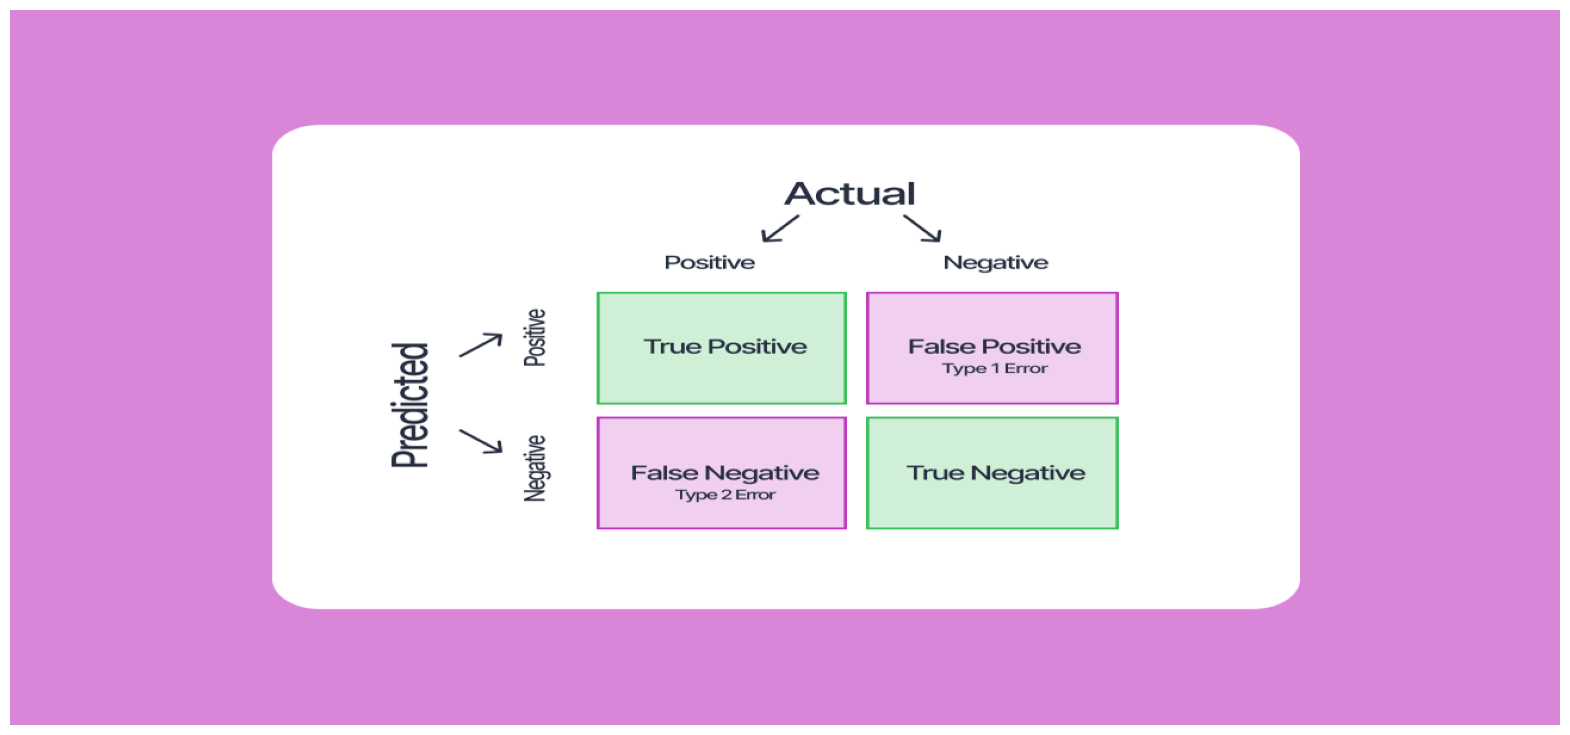

In [3]:
from PIL import Image

# Chemin vers l'image
image_path = 'Confusion.png'

# Ouvrir l'image
image = Image.open(image_path)
image = image.convert('RGB')
# Redimensionner l'image (ajuster les dimensions selon vos besoins)
image_resized = image.resize((1300, 600))

# Ajuster la taille de la figure
plt.figure(figsize=(20, 12))

# Afficher l'image
plt.imshow(image_resized)
plt.axis('off')  # Pour cacher les axes
plt.show()

## Fichier Prétraité

In [4]:
# Chargement des données depuis le fichier CSV "AnciensClients.csv"
Data = pd.read_csv(r'C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 7 ML\Application\Donnees_generees\AnciensClients.csv')
Data.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRA

In [5]:
# Affiche les dimensions du DataFrame (nombre de lignes et de colonnes)
data_shape = Data.shape
print(f"Dimensions du DataFrame : {data_shape}")

print()

# Affiche des informations générales sur le DataFrame, telles que le type de chaque colonne et le nombre de valeurs non nulles
Data_info = Data.info()

print()

# Affiche la répartition des classes pour la colonne 'TARGET', y compris les NaN (non applicable ici car 'TARGET' est binaire)
target_distribution = Data['TARGET'].value_counts(dropna=False)
print("Répartition des classes de 'TARGET' :")
print(target_distribution)

print()

# Calcul et affichage du nombre total de valeurs manquantes (NaN) dans le DataFrame
total_missing_values = Data.isna().sum().sum()
print(f"Quantité totale de valeurs manquantes (NaN) : {total_missing_values}")

print()

# Calcul et affichage du nombre total de cellules dans le DataFrame (nombre de lignes * nombre de colonnes)
total_cells = Data.shape[0] * Data.shape[1]
print(f"Nombre total de cellules dans le DataFrame : {total_cells}")

print()

# Renomme les colonnes du DataFrame en supprimant les caractères spéciaux et en conservant uniquement les lettres, chiffres et underscores
Data = Data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
print("Les colonnes du DataFrame ont été renommées pour supprimer les caractères spéciaux.")

Dimensions du DataFrame : (307506, 796)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 796 entries, TARGET to INSTAL_COUNT
dtypes: float64(796)
memory usage: 1.8 GB

Répartition des classes de 'TARGET' :
0.0    282681
1.0     24825
Name: TARGET, dtype: int64

Quantité totale de valeurs manquantes (NaN) : 63543285

Nombre total de cellules dans le DataFrame : 244774776

Les colonnes du DataFrame ont été renommées pour supprimer les caractères spéciaux.


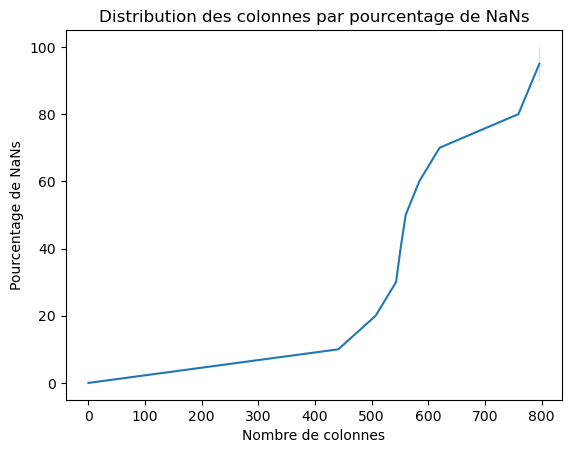

Il y a 176 variables avec plus de 70% de NaNs.
Il y a 212 variables avec plus de 60% de NaNs.
Il y a 236 variables avec plus de 50% de NaNs.
Il y a 245 variables avec plus de 40% de NaNs.
Il y a 253 variables avec plus de 30% de NaNs.



In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Calcul du pourcentage de valeurs manquantes (NaNs) par colonne
pourcentage_nan_par_colonne = (Data.isna().mean() * 100).astype(int)

# Création d'un DataFrame avec les pourcentages de NaNs
dataframe_pourcentage_nan = pd.DataFrame(pourcentage_nan_par_colonne, columns=['Pourcentage_NaNs'])

# Calcul du nombre de colonnes ayant moins de NaNs qu'un certain pourcentage
nombre_colonnes_sans_nan = [
    Data.shape[1] - dataframe_pourcentage_nan[dataframe_pourcentage_nan['Pourcentage_NaNs'] >= seuil].shape[0]
    for seuil in range(0, 110, 10)
]
liste_pourcentages_nan = list(range(0, 110, 10))

# Visualisation de la distribution des NaNs
sns.lineplot(x=nombre_colonnes_sans_nan, y=liste_pourcentages_nan)
plt.xlabel('Nombre de colonnes')
plt.ylabel('Pourcentage de NaNs')
plt.title('Distribution des colonnes par pourcentage de NaNs')
plt.show() 

# Impression du nombre de colonnes ayant plus de NaNs que certains seuils
for seuil in [70, 60, 50, 40, 30]:
    nombre_variables_avec_nan = dataframe_pourcentage_nan[dataframe_pourcentage_nan['Pourcentage_NaNs'] >= seuil].shape[0]
    print(f'Il y a {nombre_variables_avec_nan} variables avec plus de {seuil}% de NaNs.')

print()

# Sélection des colonnes avec moins de 70% de NaNs
colonnes_avec_moins_de_70_nan = list(dataframe_pourcentage_nan[dataframe_pourcentage_nan['Pourcentage_NaNs'] < 70].index)

# Filtrage des colonnes pour garder uniquement celles avec moins de 70% de NaNs
Data = Data[colonnes_avec_moins_de_70_nan]

# Création d'une copie pour le traitement sans la colonne cible
data_sans_cible = Data.copy()
del data_sans_cible['TARGET']

# Initialisation de StratifiedKFold pour créer des partitions stratifiées
stratified_kfold = StratifiedKFold(n_splits=39)

# Création des partitions de données
for indices_partie1, indices_partie2 in stratified_kfold.split(data_sans_cible, Data['TARGET']):
    partie2 = Data.loc[indices_partie2, :]
    partie1 = Data.loc[indices_partie1, :]

## Test de prédiction avec MLFlow

In [57]:
# Chargement des données des nouveaux clients à partir du fichier CSV
chemin_fichier_nouveaux_clients = r'C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 7 ML\Application\Donnees_generees\NouveauxClientsComplets.csv'
donnees_nouveaux_clients = pd.read_csv(chemin_fichier_nouveaux_clients)

# Nettoyage des noms de colonnes pour ne conserver que les caractères alphanumériques et les underscores
donnees_nouveaux_clients = donnees_nouveaux_clients.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Sélection des variables pertinentes, en conservant uniquement la première observation (1ère ligne)
donnees_client_selectionne = donnees_nouveaux_clients.iloc[0:1][colonnes_avec_moins_de_70_nan]

# Suppression de la colonne 'TARGET' si elle est présente dans les données sélectionnées
if 'TARGET' in donnees_client_selectionne.columns:
    del donnees_client_selectionne['TARGET']

# Affichage des données pour le client sélectionné
donnees_client_selectionne

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,...,PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherswithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,P

### Test API local

In [9]:
# Charger le modèle à partir d'un chemin local complet    
model_uri = r'C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 7 ML\Notebook\mlflow_runs\290555362347125930\1e46374402274ffe9572106d93203ef9\artifacts\model'
model = mlflow.sklearn.load_model(model_uri)

# Prédire les probabilités avec les données du client
model.predict_proba(donnees_client_selectionne.values.tolist())

array([[0.63895802, 0.36104198]])

In [59]:
# Avec API en local

import requests
import json

# URL de l'API locale
url = 'http://localhost:3000/api/'

# Données à envoyer
data = donnees_client_selectionne.values.tolist()

# Convertir les données en JSON
j_data = json.dumps(data)

# Définir les en-têtes
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}

# Envoyer la requête POST
r = requests.post(url, data=j_data, headers=headers)

# Imprimer la réponse brute pour débogage
print("Réponse brute du serveur :", r.text)

# Convertir la réponse JSON en objet Python
response_json = r.json()

# Accéder à la probabilité de la deuxième classe
result2 = response_json[0][1] 
prediction = int(round(result2, 2) * 100)

print(f"Prédiction : {prediction}")

Réponse brute du serveur : [[0.63895802188395,0.36104197811605]]

Prédiction : 36


- **Réponse Brute du Serveur** : `[[0.63895802188395, 0.36104197811605]]`

- **Classe 0 (probabilité = 63.89%)** : Selon notre modèle, il y a 63.89% de chances que l'observation appartienne à la classe 0.
- **Classe 1 (probabilité = 36.10%)** : Il y a 36.10% de chances que l'observation appartienne à la classe 1.

Le code renvoie donc une prédiction de 36%, ce qui signifie que notre modèle prédit que l'observation a une probabilité de 36% d'appartenir à la classe 1.


- **Décision Basée sur le Seuil** : dans une tâche de classification, nous pourrions vouloir établir un seuil pour décider à quelle classe assigner l'observation. Par exemple, si le seuil est de 60%, une observation avec une probabilité de 36% pour la classe 1 serait classée comme appartenant à la classe 0.

- **Analyse Plus Approfondie** : Nous pouvons également examiner les probabilités pour comprendre la confiance de notre modèle dans ses prédictions et ajuster nos décisions en conséquence.

### Test API distant sur Heroku

In [20]:
import requests
import json

# URL de l'API distante tester en local
url = 'http://127.0.0.1:5000/api/'  # Remplacer par l'URL réelle de l'API déployée

# Données à envoyer (listes de valeurs provenant d'un DataFrame ou d'une autre source de données)
data = donnees_client_selectionne.values.tolist()

# Convertir les données en JSON
j_data = json.dumps(data)

# Définir les en-têtes pour la requête POST
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}

# Envoyer la requête POST à l'API distante
r = requests.post(url, data=j_data, headers=headers)

# Imprimer la réponse brute du serveur pour débogage
print("Réponse brute du serveur distant :", r.text)

# Convertir la réponse JSON en objet Python
response_json = r.json()

# Vérifier la structure de la réponse et extraire la probabilité
if isinstance(response_json, list):
    result2 = response_json[0][1]  # Si la réponse est une liste de probabilités
elif isinstance(response_json, dict):
    result2 = response_json.get('probabilité', 0)  # Si la réponse est un dictionnaire contenant une probabilité
else:
    result2 = response_json  # Si la réponse est directement une probabilité (float ou int)

# Calculer la prédiction en pourcentage
prediction = int(round(result2, 2) * 100)
print(f"Prédiction : {prediction}")

Réponse brute du serveur distant : [[0.63895802188395,0.36104197811605]]

Prédiction : 36


In [ ]:
# https://predictions-app-projet7-f3b0b3d90518.herokuapp.com/

In [39]:
import requests
import json

# URL de l'API distante sur Heroku
url = 'https://predictions-app-projet7-f3b0b3d90518.herokuapp.com/api/'

# Données à envoyer (listes de valeurs provenant d'un DataFrame ou d'une autre source de données)
data = donnees_client_selectionne.values.tolist()

# Convertir les données en JSON
j_data = json.dumps(data)

# Définir les en-têtes pour la requête POST
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}

# Envoyer la requête POST à l'API distante
r = requests.post(url, data=j_data, headers=headers)

# Imprimer la réponse brute du serveur pour débogage
print("Réponse brute du serveur distant :", r.text)

# Convertir la réponse JSON en objet Python
response_json = r.json()

# Vérifier la structure de la réponse et extraire la probabilité
if isinstance(response_json, list):
    result2 = response_json[0][1]  # Si la réponse est une liste de probabilités
elif isinstance(response_json, dict):
    result2 = response_json.get('probabilité', 0)  # Si la réponse est un dictionnaire contenant une probabilité
else:
    result2 = response_json  # Si la réponse est directement une probabilité (float ou int)

# Calculer la prédiction en pourcentage
prediction = int(round(result2, 2) * 100)
print(f"Prédiction : {prediction}")

Réponse brute du serveur distant : [[0.3812914301518562,0.6187085698481438]]

Prédiction : 62
